## Import libreries

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.stats import norm
from statsmodels.stats.diagnostic import acorr_ljungbox

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load and preview the data

In [ ]:
PATH = 'RNN-Amazon'
path_models='RNN-Amazon/models'
all_models = os.listdir(path_models)
df = pd.read_csv(PATH+'/data/AmazonWeb.csv',sep = ',', parse_dates=['Fecha'], decimal=',')
df

<ipython-input-3-88dda1ea21cf>:4: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df = pd.read_csv(PATH+'/data/AmazonWeb.csv',sep = ',', parse_dates=['Fecha'], decimal=',')


,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.
0,2023-05-26,120.11,116.04,121.50,116.02,"96,78M","4,44%"
1,2023-05-25,115.00,116.63,116.87,114.31,"64,21M","-1,50%"
2,2023-05-24,116.75,115.35,117.34,115.02,"61,38M","1,53%"
3,2023-05-23,114.99,114.27,117.14,113.78,"62,46M","-0,02%"
4,2023-05-22,115.01,116.77,116.77,114.25,"70,37M","-1,07%"
...,...,...,...,...,...,...,...
2110,2015-08-01,15.02,15.02,15.16,14.81,"61,77M","0,67%"
2111,2015-07-01,14.92,14.88,15.06,14.77,"52,81M","1,08%"
2112,2015-06-01,14.76,15.11,15.15,14.62,"70,38M","-2,32%"
2113,2015-05-01,15.11,15.35,15.42,15.04,"55,48M","-2,07%"


In [ ]:
time = df['Fecha'].to_numpy() # dates column
series = df['Último'].to_numpy() # final value of the stock

In [ ]:
# Data is organized from last value [0] to first value [-1], it is important to sort it in reverse order
series

array([120.11, 115.  , 116.75, ...,  14.76,  15.11,  15.43])

In [ ]:
# Sorting data
time_ord = np.flip(time)
series_ord = np.flip(series)

In [ ]:
series_ord

array([ 15.43,  15.11,  14.76, ..., 116.75, 115.  , 120.11])

In [ ]:
# Reduce the long of the data
time_ord

array(['2015-02-01T00:00:00.000000000', '2015-05-01T00:00:00.000000000',
       '2015-06-01T00:00:00.000000000', ...,
       '2023-05-24T00:00:00.000000000', '2023-05-25T00:00:00.000000000',
       '2023-05-26T00:00:00.000000000'], dtype='datetime64[ns]')

In [ ]:
# Convert date information to array of consecutive natural numbers to plot
time_ord = time_ord.astype('datetime64[D]')
x_axis = np.arange(len(time_ord))
x_axis

array([   0,    1,    2, ..., 2112, 2113, 2114])

In [ ]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None, xticks=None, samples=4):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    show_ticks = []
    show_x = []

    ratio = int(len(xticks) / samples)
    for i in range(len(xticks)):
      if i%ratio == 0:
        show_ticks.append(xticks[i])
        show_x.append(i)

    plt.xticks(show_x, show_ticks)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

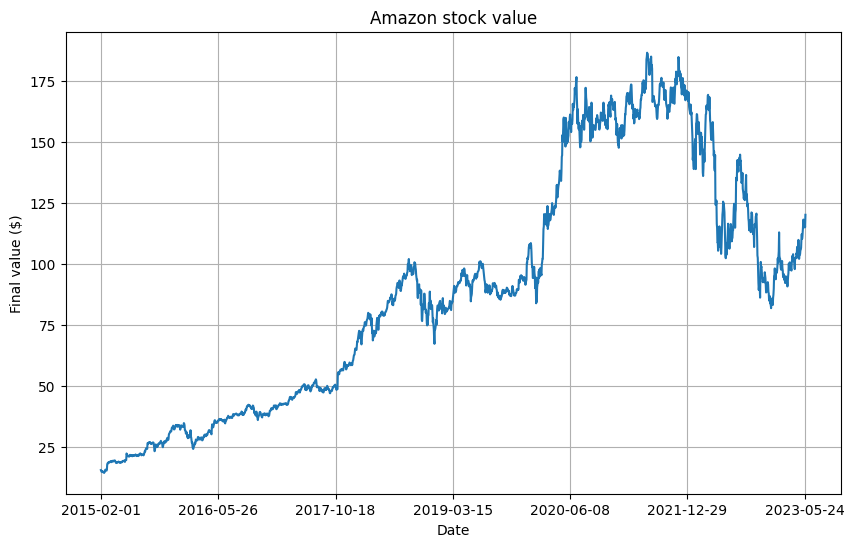

In [ ]:
# Showing data
plot_series(x_axis, series_ord, title='Amazon stock value', xlabel='Date', ylabel='Final value ($)', xticks=time_ord, samples=6)

# Max value of the series is less than 200

## Split data and create datasets

In [ ]:
# Define the split time
split_time = int(len(series_ord)*0.9) # 90% of data to train the models

# Get the train set
time_train = time_ord[:split_time]
x_train = series_ord[:split_time]

# Get the validation set
time_valid = time_ord[split_time:]
x_valid = series_ord[split_time:]

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer, pred_out):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    # It creates windows of size "window_size + pred_out"
    dataset = dataset.window(window_size + pred_out, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + pred_out))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-pred_out], window[-pred_out:]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [ ]:
# Parameters
window_size = 30
batch_size = 16
shuffle_buffer_size = 1000
pred_out = 7

# Generate the dataset windows
# The windows/batches are like tuples of "data_features + pred_out_labels"
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size, pred_out)

## LR schedules... (not executed)
Bibliography recommends use it

MLP_model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, input_shape=(window_size, 1)),
  tf.keras.layers.Dense(64),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(pred_out),
])

RNN_model = tf.keras.models.Sequential([
  tf.keras.layers.SimpleRNN(128, return_sequences = True, input_shape=(window_size, 1)),
  tf.keras.layers.SimpleRNN(64),
  tf.keras.layers.Dense(pred_out),
])

LSTM_model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(window_size, 1)),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(pred_out),
])

Bi_LSTM_model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(window_size, 1)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(pred_out),
])

Conv_LSTM_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(pred_out),
])

ConvBi_LSTM_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(pred_out),
])

GRU_model = tf.keras.models.Sequential([
  tf.keras.layers.GRU(128, return_sequences=True, input_shape=(window_size, 1)),
  tf.keras.layers.GRU(64),
  tf.keras.layers.Dense(pred_out),
])

Bi_GRU_model = tf.keras.models.Sequential([
  tf.keras.layers.GRU(128, return_sequences=True, input_shape=(window_size, 1)),
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
  tf.keras.layers.Dense(pred_out),
])

Conv_GRU_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.GRU(128, return_sequences=True),
  tf.keras.layers.GRU(64),
  tf.keras.layers.Dense(pred_out),
])

ConvBi_GRU_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.GRU(128, return_sequences=True),
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
  tf.keras.layers.Dense(pred_out),
])

optimizer = tf.keras.optimizers.SGD(momentum=0.9)
loss = tf.keras.losses.Huber()

history = LR_schedule(MLP_model, optimizer=optimizer, loss=loss, X_train=train_set)
history = LR_schedule(RNN_model, optimizer=optimizer, loss=loss, X_train=train_set)
history = LR_schedule(LSTM_model, optimizer=optimizer, loss=loss, X_train=train_set)
history = LR_schedule(Bi_LSTM_model, optimizer=optimizer, loss=loss, X_train=train_set)
history = LR_schedule(Conv_LSTM_model, optimizer=optimizer, loss=loss, X_train=train_set)
history = LR_schedule(ConvBi_LSTM_model, optimizer=optimizer, loss=loss, X_train=train_set)
history = LR_schedule(GRU_model, optimizer=optimizer, loss=loss, X_train=train_set)
history = LR_schedule(Bi_GRU_model, optimizer=optimizer, loss=loss, X_train=train_set)
history = LR_schedule(Conv_GRU_model, optimizer=optimizer, loss=loss, X_train=train_set)
history = LR_schedule(ConvBi_GRU_model, optimizer=optimizer, loss=loss, X_train=train_set)

## Train models

In [ ]:

Conv1D_MaxPool_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=[window_size, 1]),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Agregamos dropout para regularizar
    tf.keras.layers.Dense(pred_out),
    tf.keras.layers.Lambda(lambda x: x * 200)
])

In [ ]:
models_list = [Conv1D_MaxPool_model]

model_type_list = ['Conv1D_MaxPool']
model_name = []

for model_type in model_type_list:
    model_name.append(model_type+'_'+str(window_size)+'_'+str(pred_out)+'.h5')

In [ ]:
def train_model(loss, optimizer, path_models, model_name, model, X_train, epochs, patience):

  '''
      Function to train a model.
      Inputs:
      loss: loss function to evaluate the model
      optimizer: optimizer
      path_models: path to directory where the model will be saved
      model_name: name to be saved as
      model: Neural Network Model
      X_train: training data
      epochs: training epochs
      patience: epochs to wait for improvement in the model before stop training

      Outputs:
      history: object with training evolution data
  '''

  # Callback to save the best model in training
  cb1 = tf.keras.callbacks.ModelCheckpoint(
      os.path.join(path_models, model_name), monitor= 'mae' , verbose=0, save_best_only=True,
      save_weights_only=False, mode='min', save_freq='epoch'
      )

  # Callback to stop training if it isn't improving
  cb2 = tf.keras.callbacks.EarlyStopping(
      monitor= 'mae', min_delta=0.001, patience= patience, verbose=0, mode='min',
      baseline=None, restore_best_weights=True
      )

  model.compile(optimizer = optimizer, loss = loss, metrics = 'mae')

  history = model.fit(X_train, epochs = epochs, callbacks=[cb1, cb2])

  # At the beginning the error is very large, and therefore there is a large scale in which variations in the last epochs can not be seen
  # Taking from the 10th, the plot is clearer
  plt.plot(history.history['mae'][10:], label='MAE')
  plt.plot(history.history['loss'][10:], label='Huber loss')
  plt.title('Mean Absolute Error')
  plt.ylabel('MAE')
  plt.xlabel('Nº epoch')
  plt.legend(loc="upper right")
  plt.show()

  return history

Epoch 1/100
    114/Unknown - 2s 10ms/step - loss: 255.6204 - mae: 256.1195

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


117/117 [==============================] - 3s 14ms/step - loss: 251.3276 - mae: 251.8267
Epoch 2/100
117/117 [==============================] - 1s 10ms/step - loss: 40.2453 - mae: 40.7420
Epoch 3/100
117/117 [==============================] - 1s 10ms/step - loss: 37.7745 - mae: 38.2702
Epoch 4/100
117/117 [==============================] - 2s 12ms/step - loss: 37.6549 - mae: 38.1509
Epoch 5/100
117/117 [==============================] - 2s 16ms/step - loss: 34.9993 - mae: 35.4949
Epoch 6/100
117/117 [==============================] - 2s 15ms/step - loss: 33.6613 - mae: 34.1566
Epoch 7/100
117/117 [==============================] - 1s 10ms/step - loss: 33.1077 - mae: 33.6037
Epoch 8/100
117/117 [==============================] - 1s 9ms/step - loss: 32.8693 - mae: 33.3647
Epoch 9/100
117/117 [==============================] - 1s 8ms/step - loss: 32.8204 - mae: 33.3157
Epoch 10/100
117/117 [==============================] - 1s 8ms/step - loss: 32.5131 - mae: 33.0081
Epoch 11/100
117/117 [

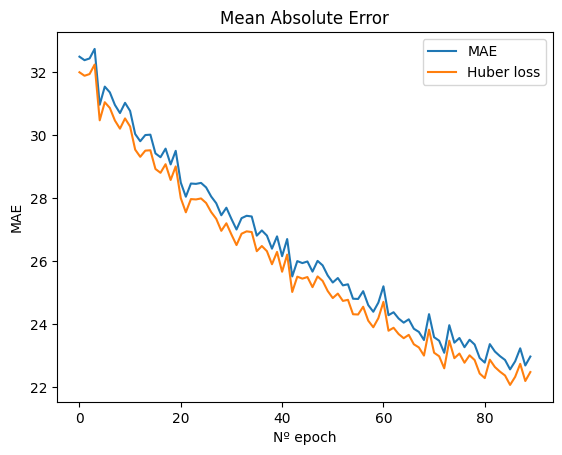

In [ ]:
tf.keras.backend.clear_session()

epochs = 100
patience = 30
LR = 1e-07

history_train = []

for i in range(1):
    history_train.append(train_model(tf.keras.losses.Huber(), tf.keras.optimizers.SGD(learning_rate=LR, momentum=0.9),
                        path_models=path_models, model_name=model_name[i], model=models_list[i],
                        X_train=train_set,
                        epochs=epochs, patience=patience))

## Models evaluation

In [ ]:

from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_model(path_model, model_name, serie, x_valid, window_size, batch_size, step, graph, pred_out=1):

    '''
        Function to evaluate a model.
        Inputs:
        path_models: path to directory from where the model will be load
        model_name: name of the model
        X_test, Y_test: evaluation data
        sc_price: object to transform data
        step: factor of bins for residual histogram

        Outputs:
        mse, mae: mean square error and mean absolute error
    '''

    model_loaded = tf.keras.models.load_model(os.path.join(path_model, model_name))

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(serie)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    forecast = model_loaded.predict(dataset)
    if pred_out > 1:
        x_valid1 = []
        for i in range(len(x_valid)-pred_out+1):
            x_valid1.append(x_valid[i:i+pred_out])

    else:
        x_valid1 = x_valid[:]

    mae = mean_absolute_error(x_valid1, forecast.squeeze())

    #copy of the input lists
    true = x_valid1[:]
    pred = forecast.squeeze()[:]

    #empty list to allocate  residuals
    residual = true-pred

    res_m = np.mean(residual)
    res_var = np.var(residual)

    residual1 = []
    if pred_out > 1:
      # check if arrays have the same dimension
      for cicle in range(len(true)):
        # cicle has the amount of outputs
        for item in range(len(true[cicle])):
          residual1.append(true[cicle][item] - pred[cicle][item])
    else:
       residual1 = residual[:]

    if graph:
        plt.figure(figsize=(10, 10))
        plt.plot(x_valid, 'b', label = 'true values')
        plt.plot(forecast.squeeze(), 'r', label = 'predictions')
        plt.title('Comparision')
        plt.ylabel('Price')
        plt.xlabel('Time')
        plt.show()



        # Plot residual graph to evaluate data distribution
        plt.figure(figsize=(10, 10))
        plt.plot(residual1, 'b', label = 'Residuals')
        plt.title('Residuals graph')
        plt.ylabel('Residual value')
        plt.xlabel('Number of predictions')
        plt.legend(loc = 'upper left')
        plt.show()

        # Min and max to plot the histogram
        minim = np.min(residual1)
        maxim = np.max(residual1)

        # Number of bars in the histogram
        bins = int(abs((maxim - minim) / step))

        #convert to pandas dataframe to use the function hist from that library
        df = pd.DataFrame(residual1, columns = ['Residuals Histogram'])
        hist = df.hist(bins = bins, figsize=(10,10))

    return mae, res_m, res_var

13/13 [==============================] - 0s 8ms/step


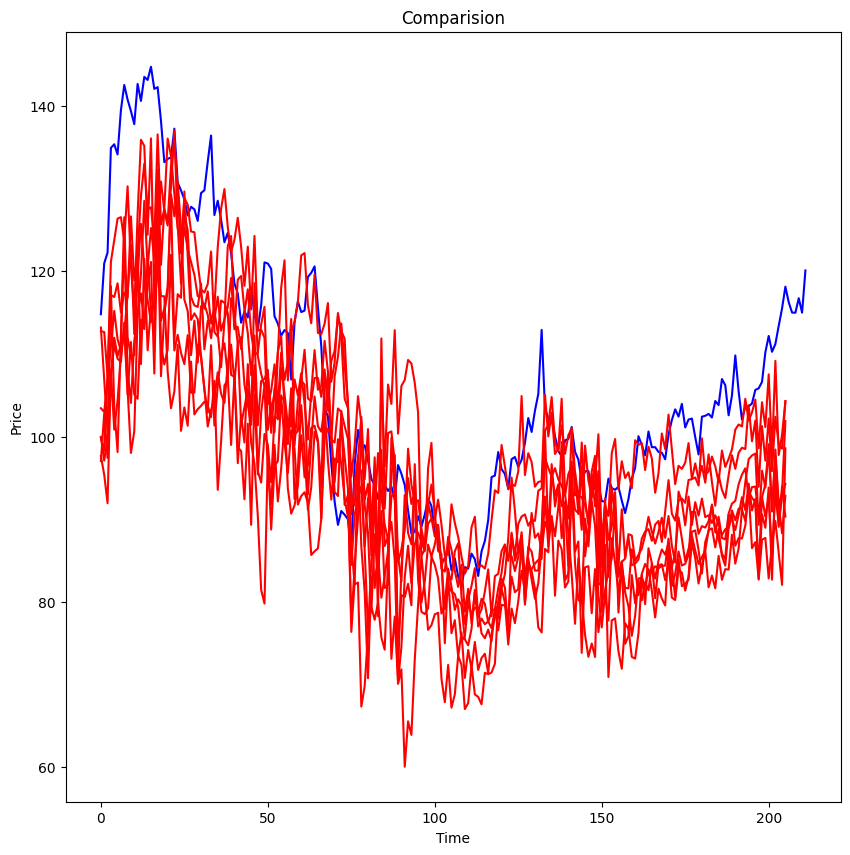

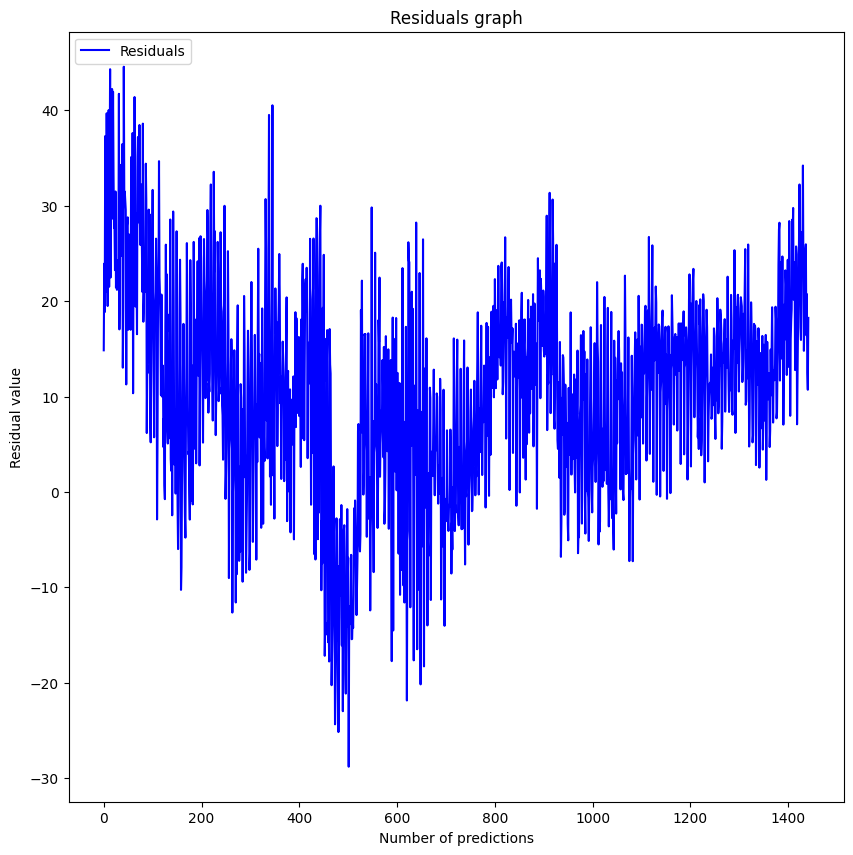

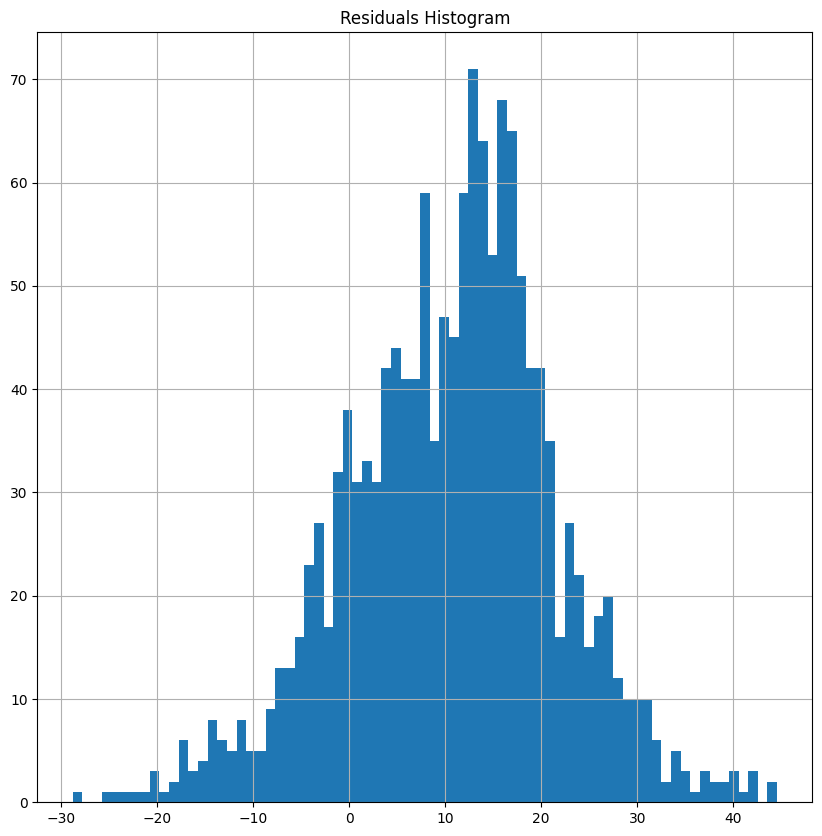

In [ ]:
model_type_list_red = ['Conv1D']

metrics = []

for arch in model_type_list_red:

    for model in all_models:

        if arch in model:

            options = model.split('_')

            if options[-1] == str(pred_out) + '.h5' and options[-2] == str(window_size):

                metrics.append([model, evaluate_model(path_models, model, series_ord[split_time-window_size:-pred_out], x_valid, window_size, batch_size, step=1, graph=True, pred_out=pred_out)])


In [ ]:
metrics

[['MLP_30_7.h5', (11.089767435737857, -5.61631833016955, 183.57523310860194)],
 ['RNN_30_7.h5', (5.295355932947336, -2.8471428416935973, 44.39594142422733)],
 ['LSTM_30_7.h5', (7.663827678241285, -3.4755625564215413, 87.20462902089763)],
 ['Bi_LSTM_30_7.h5',
  (9.876090009797796, -2.9813802184212053, 139.66874108105156)],
 ['Conv_LSTM_30_7.h5',
  (6.599429470490814, -2.7693656193366825, 69.98221893226643)],
 ['ConvBi_LSTM_30_7.h5',
  (9.92441440513495, -3.0238246036270287, 144.36319199933507)],
 ['GRU_30_7.h5', (6.5876156918847135, -1.2263864040507024, 75.3618975236072)],
 ['Bi_GRU_30_7.h5',
  (10.011432642414237, -3.9680551740035264, 140.4722815113058)],
 ['Conv_GRU_30_7.h5',
  (5.614708021695671, -0.5988120653890537, 57.60346899803732)],
 ['ConvBi_GRU_30_7.h5',
  (7.178094768550627, -3.8349601853538644, 74.71473620860138)],
 ['Conv1D_MaxPool_30_7.h5',
  (12.761115193254577, 10.67296505455832, 118.48637667984016)]]

In [ ]:
names = [metric[0] for metric in metrics]
values = [metric[1] for metric in metrics]

mae = [value[0] for value in values]
mean = [np.abs(value[1]) for value in values]
var = [np.abs(value[2]) for value in values]

In [ ]:
names

['MLP_30_7.h5',
 'RNN_30_7.h5',
 'LSTM_30_7.h5',
 'Bi_LSTM_30_7.h5',
 'Conv_LSTM_30_7.h5',
 'ConvBi_LSTM_30_7.h5',
 'GRU_30_7.h5',
 'Bi_GRU_30_7.h5',
 'Conv_GRU_30_7.h5',
 'ConvBi_GRU_30_7.h5',
 'Conv1D_MaxPool_30_7.h5']

In [ ]:
names_axis = [''.join(name.split('_')[:-2]) for name in names]
names_axis

['MLP',
 'RNN',
 'LSTM',
 'BiLSTM',
 'ConvLSTM',
 'ConvBiLSTM',
 'GRU',
 'BiGRU',
 'ConvGRU',
 'ConvBiGRU',
 'Conv1DMaxPool']

<ipython-input-29-31aaea768c82>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(names_axis, fontsize = 12, rotation=60)
<ipython-input-29-31aaea768c82>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(names_axis, fontsize = 12, rotation=60)
<ipython-input-29-31aaea768c82>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(names_axis, fontsize = 12, rotation=60)


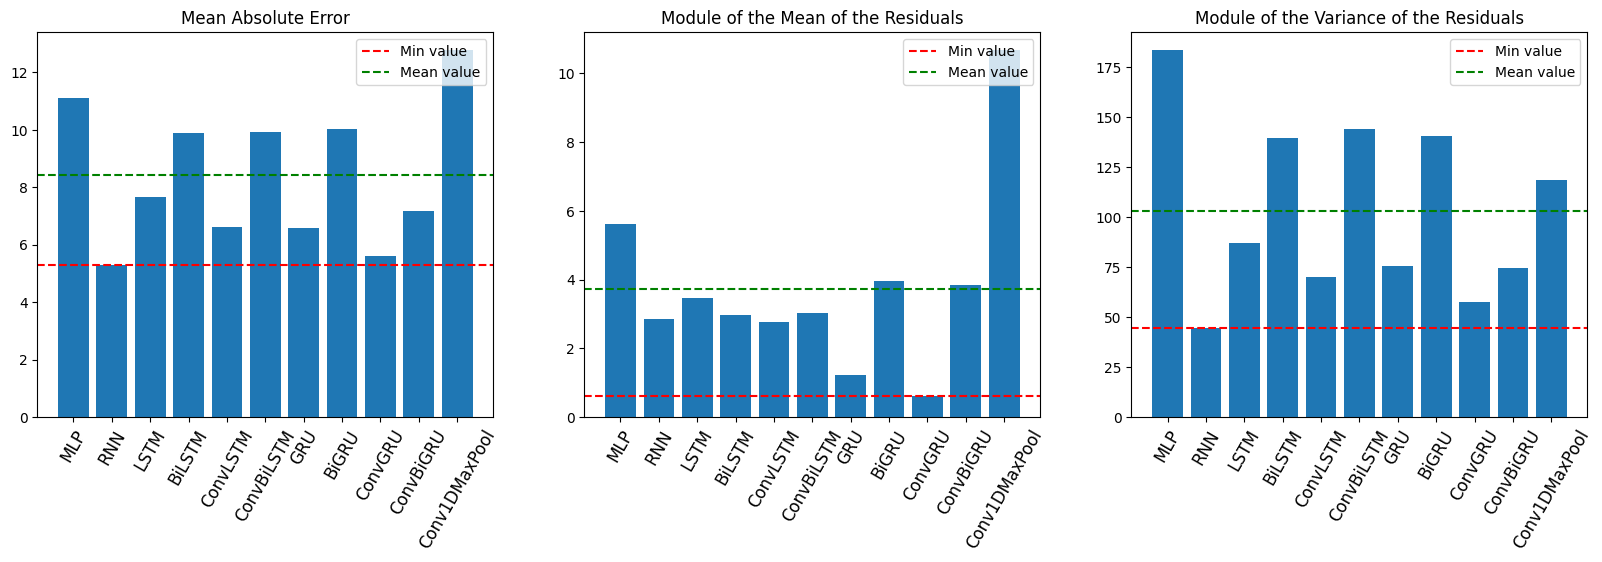

In [ ]:
fig, axs = plt.subplots(1,3, figsize = (20,5))

axs[0].bar(names_axis, mae)
axs[0].axhline(y=np.min(mae), color='red', linestyle='--', label='Min value')
axs[0].axhline(y=np.mean(mae), color='green', linestyle='--', label='Mean value')
axs[0].set_xticklabels(names_axis, fontsize = 12, rotation=60)
axs[0].set_title('Mean Absolute Error')
axs[0].legend(loc='upper right')

axs[1].bar(names_axis, mean)
axs[1].axhline(y=np.min(mean), color='red', linestyle='--', label='Min value')
axs[1].axhline(y=np.mean(mean), color='green', linestyle='--', label='Mean value')
axs[1].set_xticklabels(names_axis, fontsize = 12, rotation=60)
axs[1].set_title('Module of the Mean of the Residuals')
axs[1].legend(loc='upper right')

axs[2].bar(names_axis, var)
axs[2].axhline(y=np.min(var), color='red', linestyle='--', label='Min value')
axs[2].axhline(y=np.mean(var), color='green', linestyle='--', label='Mean value')
axs[2].set_xticklabels(names_axis, fontsize = 12, rotation=60)
axs[2].set_title('Module of the Variance of the Residuals')
axs[2].legend(loc='upper right')

plt.show()